## Methods of Time Series Anormaly Detection

- SVM
- Autoencoder
- Arima
- STL
- Statistical Process Control (SPC)
- Moving Average: The moving average assumes that the time series data is stationary and does not change over time, which may not always be accurate.
- Exponential smoothing: Exponential smoothing assumes that the time series data doesn’t change over time and stays the same, which isn’t always true.
Exponential smoothing can be used in energy management to detect short-term fluctuations in energy consumption.
- Autoregressive Integrated Moving Average (ARIMA)
- LSTM Neural Networks
- Bayesian Online Changepoint Detection (BOCD)
- prophet

### Step 1:

- Encoder: Imagine this step is convert data into lower dimension representation or can be termed as latent space, this step is required to decompose the data to make it more visible for identifying any pattern.

- Decoder: It reconstruct the original data from compressed representation.

### Step 2:

Training: During a training process the goal is to minimize the difference between the input and the reconstructed output. This can be achived using either mean squared error (MSE) or other loss functions.

### Step 3:

Reconstruction Error: Once training is completed, it should be able to recreate the normal example with low error. When it encounter an anomalous example, the reconstruction error would be higher in that case as model has not seen this while training and hence it’ll be flagged as anomaly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta

ModuleNotFoundError: No module named 'absl'

In [5]:
## Load ticker and define the start and end date, here we are taking 5 years of daily data.

tickers = ['^NSEI']
start = (datetime.datetime.today() - relativedelta(years=5)).strftime('%Y-%m-%d')
end = datetime.datetime.today().strftime('%Y-%m-%d')


In [8]:
tickers[0]

'^NSEI'

We are taking two feature to analyse anomaly. Return and Volume. In case of missing volume data, we are interpolating using cubic spline method.

In [9]:
Symbol = tickers
nifty_data = yf.download(tickers,start = start,end=end,interval='1d')
nifty_data['Volume'].interpolate(method ='cubic', limit_direction ='forward')
nifty_data['Volume'] = nifty_data['Volume'].replace(0,nifty_data['Volume'].mean())
nifty_data['Return'] = nifty_data['Close'].pct_change()
nifty_data['Vol_Return'] = nifty_data['Volume'].pct_change()
nifty_data.dropna(how='any',inplace=True)
# Select features
features = ['Return', 'Vol_Return']  # Assuming 'Close' represents the daily closing price
data = nifty_data[features]
# Function to clean dataset.
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

[*********************100%***********************]  1 of 1 completed


In [11]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(clean_dataset(data))

# Split data into train and test sets
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]

C:\Users\fa028\AppData\Local\Temp\ipykernel_12812\4030093098.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [13]:
# Define autoencoder architecture
input_dim = len(features) ## it is 2 in this case
encoding_dim = 2
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = tf.keras.layers.Dense(input_dim, activation='relu')(encoder_layer)
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder_layer)

In [14]:
# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Train autoencoder
autoencoder.fit(train_data, train_data, epochs=1000, batch_size=64, validation_data=(test_data, test_data))

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2687 - val_loss: 0.2494
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2425 - val_loss: 0.2284
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2267 - val_loss: 0.2125
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2090 - val_loss: 0.2011
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1998 - val_loss: 0.1934
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1931 - val_loss: 0.1883
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1870 - val_loss: 0.1852
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1857 - val_loss: 0.1834
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1866 - val_loss: 0.1824
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1820 - val_loss: 0.1820
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1826 - val_loss: 0.1817
Epoch 12/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/s

In [16]:
# Reconstruct data using autoencoder
reconstructed_data = autoencoder.predict(data_scaled)

# Calculate reconstruction error
mse = np.mean(np.power(data_scaled - reconstructed_data, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)  # Adjust threshold as needed

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


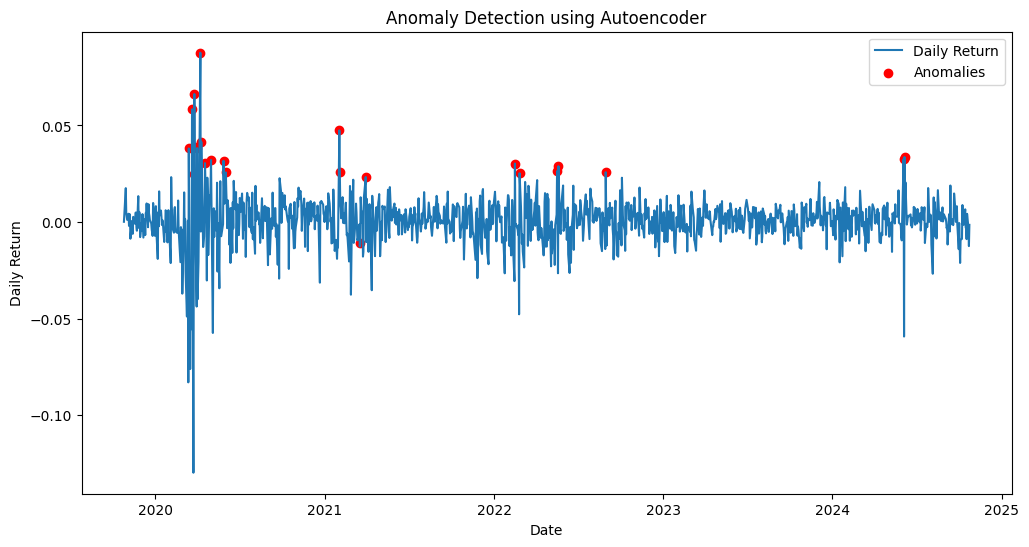

In [19]:
# Detect anomalies
anomalies = np.where(mse > threshold)[0]

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Return'], label='Daily Return')
plt.scatter(data.index[anomalies], data['Return'].iloc[anomalies], color='red', label='Anomalies')
plt.title('Anomaly Detection using Autoencoder')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
#plt.savefig(Path+Symbol+".jpeg",dpi=300)
plt.show()